In [2]:
import pandas as pd
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
listings = pd.read_csv('listing.csv')

c:\users\garis\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (94) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
## seeing all the columns we have
listings.columns


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

In [8]:
columns = ['id', 'name',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet',
       'price', 'cleaning_fee', 'guests_included', 'extra_people', 
       'minimum_nights', 'maximum_nights', 
       'has_availability', 'availability_30', 
       'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy']

In [9]:
listings_reduced = listings[columns]
print(listings_reduced.shape)

(20677, 32)


In [10]:
## We will be foucing on the listings which are availbale regularly
listings_reduced = listings_reduced[listings_reduced['has_availability'] == 't']
listings_reduced.shape

(20677, 32)

In [11]:
listings_reduced = listings_reduced[listings_reduced['availability_30'] != 0]
listings_reduced.shape

(7642, 32)

In [12]:
listings_reduced.drop(['has_availability', 'availability_30'], axis=1, inplace=True)
listings_reduced.shape

(7642, 30)

In [13]:
### We will be focusing on the listings which are valid hence we will remove the other listings which have zero price
listings_reduced = listings_reduced[listings_reduced['price'] != 0]
listings_reduced = listings_reduced[listings_reduced['number_of_reviews'] != 0]
listings_reduced = listings_reduced[listings_reduced['review_scores_rating'].notnull()]
listings_reduced.shape


(6552, 30)

# handling with the missing values

In [14]:
def examine_missing_values(data):
    data_na= data.isnull().sum().sort_values(ascending=False)
    data_na_percent = (data.isnull().sum()/len(data)*100).sort_values(ascending=False)
    missing_data = pd.concat([data_na, data_na_percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [16]:
missing_data = examine_missing_values(listings_reduced)
missing_data.head(30)

,Total,Percent
square_feet,6382,97.405372
cleaning_fee,857,13.079976
beds,2,0.030525
review_scores_communication,1,0.015263
bathrooms,1,0.015263
bedrooms,1,0.015263
price,0,0.000000
name,0,0.000000
neighbourhood_cleansed,0,0.000000
latitude,0,0.000000


In [17]:
# We will be dropping the columns with high null value as they do not contribute with our search
listings_reduced.drop(['square_feet'], axis=1, inplace=True)
listings_reduced.shape

(6552, 29)

In [18]:
#If a review score for a sub-catogery is missing, we fill it by its average review score which is review_score_rating.
listings_reduced['review_scores_value'].fillna(listings_reduced['review_scores_rating'], inplace=True)
listings_reduced['review_scores_location'].fillna(listings_reduced['review_scores_rating'], inplace=True)
listings_reduced['review_scores_communication'].fillna(listings_reduced['review_scores_rating'], inplace=True)
listings_reduced['review_scores_checkin'].fillna(listings_reduced['review_scores_rating'], inplace=True)

In [19]:
# If the values of bathrooms, bedrooms, beds are missing, we can understand there is no bathroom, bedroom, bed in this property. So, we fill them by 0.
listings_reduced['bathrooms'].fillna(0, inplace=True)
listings_reduced['bedrooms'].fillna(0, inplace=True)
listings_reduced['beds'].fillna(0, inplace=True)

In [21]:
#We fill the missing cleaning fee by mode.
listings_reduced['cleaning_fee'].fillna(listings_reduced['cleaning_fee'].mode()[0], inplace=True)


In [23]:
missing_data = examine_missing_values(listings_reduced)
missing_data.head(20)

,Total,Percent
cancellation_policy,0,0.0
cleaning_fee,0,0.0
name,0,0.0
neighbourhood_cleansed,0,0.0
latitude,0,0.0
longitude,0,0.0
property_type,0,0.0
room_type,0,0.0
accommodates,0,0.0
bathrooms,0,0.0


In [24]:
listings_reduced.shape

(6552, 29)

In [ ]:
#Converting the type

In [25]:
numeric_features = list(listings_reduced.dtypes[listings_reduced.dtypes != 'object'].index)
numeric_features.remove('id')
numeric_features.remove('latitude')
numeric_features.remove('longitude')
numeric_features

['accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [26]:
category_features = list(listings_reduced.dtypes[listings_reduced.dtypes == 'object'].index)
category_features.remove('name')
category_features

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'price',
 'cleaning_fee',
 'extra_people',
 'instant_bookable',
 'is_business_travel_ready',
 'cancellation_policy']

In [27]:
listings_reduced['price'] = listings_reduced['price'].apply(lambda x:x.lstrip('$'))
listings_reduced['price'] = listings_reduced['price'].apply(lambda x:x.replace(',',''))
listings_reduced['price'] = listings_reduced['price'].astype('float')
listings_reduced['cleaning_fee'] = listings_reduced['cleaning_fee'].apply(lambda x:x.lstrip('$'))
listings_reduced['cleaning_fee'] = listings_reduced['cleaning_fee'].astype('float')
listings_reduced['extra_people'] = listings_reduced['extra_people'].apply(lambda x:x.lstrip('$'))
listings_reduced['extra_people'] = listings_reduced['extra_people'].astype('float')

In [28]:
numeric_features.extend(['cleaning_fee', 'extra_people'])
numeric_features

['accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'cleaning_fee',
 'extra_people']

In [29]:
category_features.remove('price')
category_features.remove('cleaning_fee')
category_features.remove('extra_people')

In [30]:
listings_reduced.columns = ['neighbourhood' if x=='neighbourhood_cleansed' else x for x in listings_reduced.columns]
features = listings_reduced
print(features.shape)
features.head()

(6552, 29)


,id,name,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy
0,2818,Quiet Garden View Room & Super Fast WiFi,Oostelijk Havengebied - Indische Buurt,52.36575,4.94142,Apartment,Private room,2,1.5,1.0,...,98.0,10.0,10.0,10.0,10.0,10.0,10.0,t,f,strict_14_with_grace_period
2,25428,Lovely apt in City Centre (w.lift) near Jordaan,Centrum-West,52.37297,4.88339,Apartment,Entire home/apt,3,1.0,1.0,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,strict_14_with_grace_period
3,27886,"Romantic, stylish B&B houseboat in canal district",Centrum-West,52.38673,4.89208,Houseboat,Private room,2,1.0,1.0,...,99.0,10.0,10.0,10.0,10.0,10.0,10.0,t,f,strict_14_with_grace_period
4,28871,Comfortable double room,Centrum-West,52.36719,4.89092,Apartment,Private room,2,1.0,1.0,...,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,moderate
5,29051,Comfortable single room,Centrum-West,52.36773,4.89151,Apartment,Private room,1,1.0,1.0,...,95.0,10.0,9.0,10.0,10.0,10.0,10.0,f,f,moderate


In [31]:
category_features.remove('neighbourhood_cleansed')
category_features.append('neighbourhood')
category_features

['property_type',
 'room_type',
 'bed_type',
 'instant_bookable',
 'is_business_travel_ready',
 'cancellation_policy',
 'neighbourhood']

In [32]:
#Correct highly skewed numerical features
skew_features = features[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

In [34]:
# Get dummy hot one encoding
def one_hot_encode(data, columns):
    onehot = pd.get_dummies(data[columns])
    onehot['id'] = data['id']
    # move id column to the first column
    fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
    onehot = onehot[fixed_columns]
    return onehot

In [35]:
features_onehot = one_hot_encode(features, category_features)
features_onehot.head()

,id,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,...,neighbourhood_Noord-Oost,neighbourhood_Noord-West,neighbourhood_Oostelijk Havengebied - Indische Buurt,neighbourhood_Osdorp,neighbourhood_Oud-Noord,neighbourhood_Oud-Oost,neighbourhood_Slotervaart,neighbourhood_Watergraafsmeer,neighbourhood_Westerpark,neighbourhood_Zuid
0,2818,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,25428,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27886,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,28871,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,29051,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
## Now we will see our price variable distrubution
def check_dist(price):
    print('Checking the statistical distribution of prices')
    print(price.describe())
    
    print('Fitting the prices into normal distribution')
    sns.distplot(price, fit=norm)

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(price)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('Price distribution')

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(price, plot=plt)
    plt.show()

Checking the statistical distribution of prices
count    6552.000000
mean      170.446276
std       196.396534
min         0.000000
25%       100.000000
50%       140.000000
75%       199.000000
max      8915.000000
Name: price, dtype: float64
Fitting the prices into normal distribution

 mu = 170.45 and sigma = 196.38



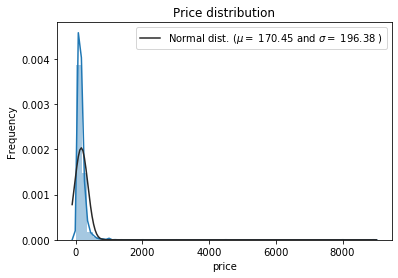

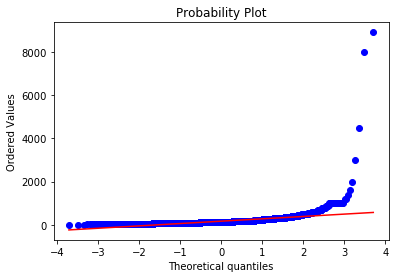

In [40]:
check_dist(features['price'])


In [ ]:
#We can see in the above plots that our price variable is skewed and there are several outliers in the price above 2000. 
#We are going to remove the outliers and to distribute the price by log function.

In [41]:
features = features[features['price']<2000]


In [44]:
def correct_dist(price):
    price = np.log1p(price)

    #Check the new distribution 
    sns.distplot(price , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(price)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('Price distribution')

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(price, plot=plt)
    plt.show()
    return price


 mu = 4.97 and sigma = 0.53



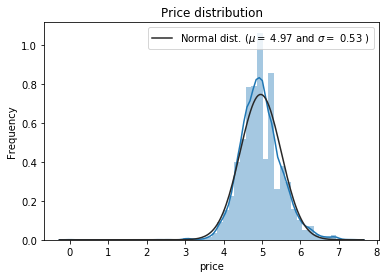

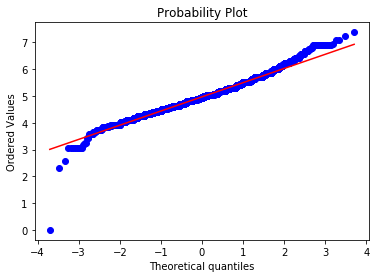

<ipython-input-45-d99433f3194e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['corrected_price'] = correct_dist(features['price'])


In [45]:
features['corrected_price'] = correct_dist(features['price'])


In [46]:
neighbourhood_count = pd.DataFrame({'neighbourhood': features['neighbourhood'].value_counts().index, 
                                    'count': features['neighbourhood'].value_counts().values})
neighbourhood_count.head()

,neighbourhood,count
0,Centrum-West,1000
1,De Baarsjes - Oud-West,962
2,De Pijp - Rivierenbuurt,714
3,Centrum-Oost,694
4,Zuid,455


In [47]:
neighbourhood_price = features.groupby('neighbourhood').median()['price']
neighbourhood_price = pd.DataFrame({'neighbourhood':neighbourhood_price.index, 'price': neighbourhood_price.T.values})
neighbourhood_price.sort_values('price', ascending=False, inplace=True)
neighbourhood_price.head()

,neighbourhood,price
4,Centrum-Oost,160.0
5,Centrum-West,160.0
8,De Pijp - Rivierenbuurt,150.0
21,Zuid,149.0
7,De Baarsjes - Oud-West,140.0


In [49]:
features_merged_dummy = pd.merge(features, features_onehot)
features_merged_dummy.head()

,id,name,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,neighbourhood_Noord-Oost,neighbourhood_Noord-West,neighbourhood_Oostelijk Havengebied - Indische Buurt,neighbourhood_Osdorp,neighbourhood_Oud-Noord,neighbourhood_Oud-Oost,neighbourhood_Slotervaart,neighbourhood_Watergraafsmeer,neighbourhood_Westerpark,neighbourhood_Zuid
0,2818,Quiet Garden View Room & Super Fast WiFi,Oostelijk Havengebied - Indische Buurt,52.36575,4.94142,Apartment,Private room,0.877118,0.771668,0.744541,...,0,0,1,0,0,0,0,0,0,0
1,25428,Lovely apt in City Centre (w.lift) near Jordaan,Centrum-West,52.37297,4.88339,Apartment,Entire home/apt,1.046565,0.608098,0.744541,...,0,0,0,0,0,0,0,0,0,0
2,27886,"Romantic, stylish B&B houseboat in canal district",Centrum-West,52.38673,4.89208,Houseboat,Private room,0.877118,0.608098,0.744541,...,0,0,0,0,0,0,0,0,0,0
3,28871,Comfortable double room,Centrum-West,52.36719,4.89092,Apartment,Private room,0.877118,0.608098,0.744541,...,0,0,0,0,0,0,0,0,0,0
4,29051,Comfortable single room,Centrum-West,52.36773,4.89151,Apartment,Private room,0.600077,0.608098,0.744541,...,0,0,0,0,0,0,0,0,0,0


In [50]:
features_merged_dummy.drop(category_features, axis=1, inplace=True)
features_merged_dummy.head()

,id,name,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,...,neighbourhood_Noord-Oost,neighbourhood_Noord-West,neighbourhood_Oostelijk Havengebied - Indische Buurt,neighbourhood_Osdorp,neighbourhood_Oud-Noord,neighbourhood_Oud-Oost,neighbourhood_Slotervaart,neighbourhood_Watergraafsmeer,neighbourhood_Westerpark,neighbourhood_Zuid
0,2818,Quiet Garden View Room & Super Fast WiFi,52.36575,4.94142,0.877118,0.771668,0.744541,0.855087,59.0,21.356256,...,0,0,1,0,0,0,0,0,0,0
1,25428,Lovely apt in City Centre (w.lift) near Jordaan,52.37297,4.88339,1.046565,0.608098,0.744541,0.590211,125.0,16.077928,...,0,0,0,0,0,0,0,0,0,0
2,27886,"Romantic, stylish B&B houseboat in canal district",52.38673,4.89208,0.877118,0.608098,0.744541,0.590211,150.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,28871,Comfortable double room,52.36719,4.89092,0.877118,0.608098,0.744541,0.590211,75.0,18.805587,...,0,0,0,0,0,0,0,0,0,0
4,29051,Comfortable single room,52.36773,4.89151,0.600077,0.608098,0.744541,0.590211,55.0,18.805587,...,0,0,0,0,0,0,0,0,0,0


# EDA

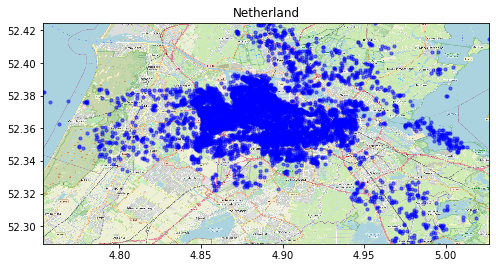

In [87]:
BBox = ((features_merged_dummy.longitude.min(),   features_merged_dummy.longitude.max(),      
         features_merged_dummy.latitude.min(), features_merged_dummy.latitude.max()))
        
ruh_m = plt.imread('map.png')
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(features_merged_dummy.longitude, features_merged_dummy.latitude, zorder=1, alpha= 0.5, c='b', s=10)
ax.set_title('Netherland')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

In [90]:
#When did the first and last host joined the airbnb and the price they listed
listings.host_since = pd.to_datetime(listings.host_since) 
d = listings.loc[listings['host_since'].idxmin()]
e = listings.loc[listings['host_since'].idxmax()]
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(listings.host_since).strftime('%d %B %Y')} with price {d.price} in neighbourhood {d.neighbourhood_cleansed}") 
print(f"And the most recent joined on {max(listings.host_since).strftime('%d %B %Y')} with price {e.price} in neighbourhood {e.neighbourhood_cleansed}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 24 September 2008 with price $59.00 in neighbourhood Oostelijk Havengebied - Indische Buurt
And the most recent joined on 08 August 2019 with price $160.00 in neighbourhood Centrum-West.


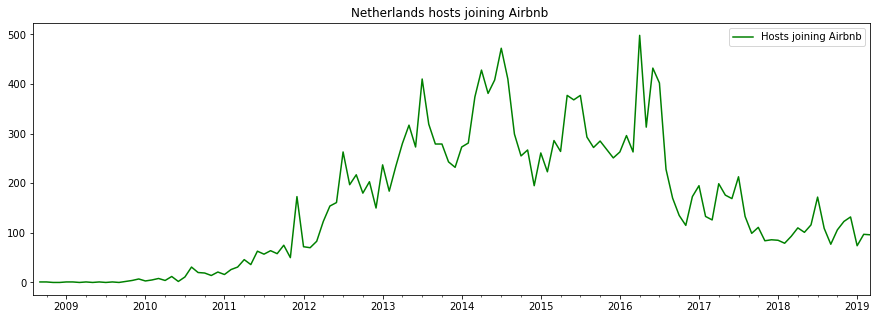

In [92]:
plt.figure(figsize=(15,5))
listings.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='green')
plt.title('Netherlands hosts joining Airbnb ')
plt.legend()
plt.xlim('2008-08-01', '2019-03-31') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [93]:
# List of the largest host_listings_count and the year the host joined Airbnb
listings.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
13610,2015-10-16,99.0
8829,2011-12-02,115.0
18381,2018-07-12,131.0
15826,2012-07-07,139.0
16397,2016-04-05,217.0
13900,2016-06-06,435.0
12752,2014-08-12,486.0
20651,2018-03-12,739.0
14445,2017-03-22,980.0
20402,NaT,NaN


In [94]:
print(f"Nightly advertised prices range from £{min(features_merged_dummy.price)} to £{max(features_merged_dummy.price)}.")


Nightly advertised prices range from f0.0 to f1600.0.


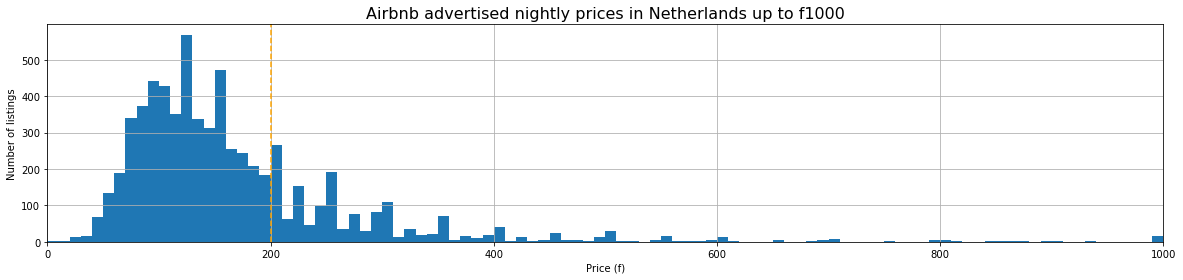

In [146]:
# Distribution of prices from f0 to f1000
plt.figure(figsize=(20,4))
features_merged_dummy.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in Netherlands up to f1000", fontsize=16)
plt.xlabel("Price (f)")
plt.ylabel("Number of listings")
plt.show()

#### Number of the property types in netherlands

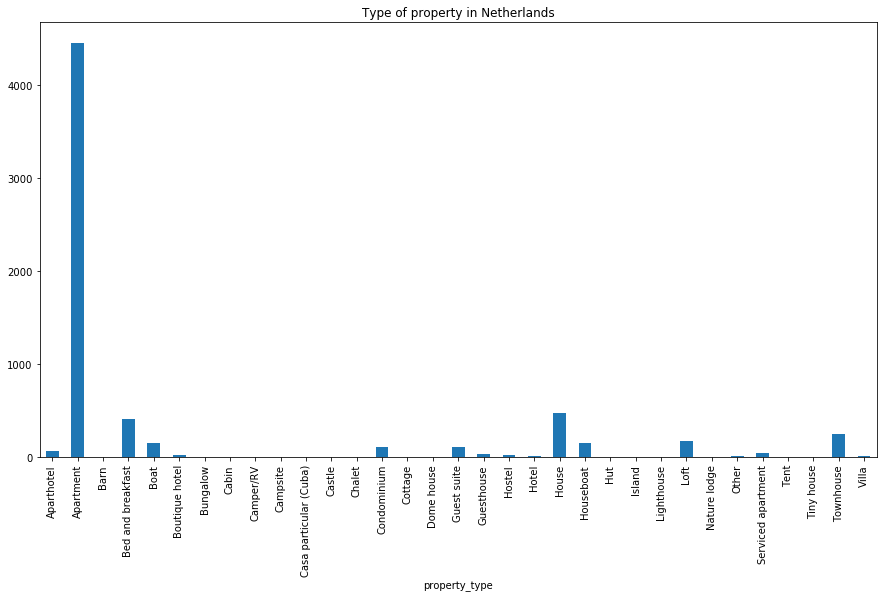

In [97]:
property_type_df = listings_reduced.groupby('property_type').id.count()
property_type_df = property_type_df.reset_index()
property_type_df = property_type_df.rename(columns={'id': 'number_of_listings'})
objects = property_type_df['property_type']
y_pos = property_type_df['number_of_listings']

property_type_df.plot.bar(x = 'property_type',
                          y = 'number_of_listings',
                          figsize = (15, 8),
                          title = 'Type of property in Netherlands',
                          legend = False)


#### What is thecostly property and room type 

In [98]:
room_property_df = listings_reduced.groupby(['property_type', 'room_type']).price.mean()
room_property_df = room_property_df.reset_index()
room_property_df = room_property_df.sort_values('price', ascending=[0])
room_property_df


,property_type,room_type,price
44,Lighthouse,Entire home/apt,4500.000000
22,Castle,Entire home/apt,550.000000
34,Hostel,Shared room,447.500000
35,Hotel,Private room,364.857143
33,Hostel,Private room,310.000000
58,Villa,Entire home/apt,281.250000
51,Serviced apartment,Entire home/apt,277.885714
39,Houseboat,Entire home/apt,270.696203
45,Loft,Entire home/apt,263.921875
56,Townhouse,Entire home/apt,256.026667


#### How many istings are available in 30 days. I have only kept 30 because netherlands only allow one 
#### month booking as per the new policy

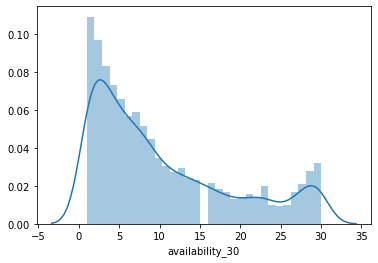

In [130]:
sns.distplot(listings[(listings['availability_30'] <= 30) & (listings['availability_30'] > 0)]['availability_30'], bins=31)
plt.ioff()

# Modelling

In [51]:
y = features_merged_dummy['corrected_price']
X = features_merged_dummy.drop(['id', 'name', 'latitude', 'longitude', 'price', 'corrected_price'], axis=1)
X.shape

(6547, 88)

In [52]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 95:
        overfit.append(i)
overfit

['property_type_Aparthotel',
 'property_type_Barn',
 'property_type_Boat',
 'property_type_Boutique hotel',
 'property_type_Bungalow',
 'property_type_Cabin',
 'property_type_Camper/RV',
 'property_type_Campsite',
 'property_type_Casa particular (Cuba)',
 'property_type_Castle',
 'property_type_Chalet',
 'property_type_Condominium',
 'property_type_Cottage',
 'property_type_Dome house',
 'property_type_Guest suite',
 'property_type_Guesthouse',
 'property_type_Hostel',
 'property_type_Hotel',
 'property_type_Houseboat',
 'property_type_Hut',
 'property_type_Island',
 'property_type_Lighthouse',
 'property_type_Loft',
 'property_type_Nature lodge',
 'property_type_Other',
 'property_type_Serviced apartment',
 'property_type_Tent',
 'property_type_Tiny house',
 'property_type_Townhouse',
 'property_type_Villa',
 'room_type_Shared room',
 'bed_type_Airbed',
 'bed_type_Couch',
 'bed_type_Futon',
 'bed_type_Pull-out Sofa',
 'bed_type_Real Bed',
 'is_business_travel_ready_f',
 'cancellation_

In [53]:
X.drop(overfit, axis=1, inplace=True)
X.shape

(6547, 34)

In [54]:
X.columns


Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_House',
       'room_type_Entire home/apt', 'room_type_Private room',
       'instant_bookable_f', 'instant_bookable_t',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict_14_with_grace_period',
       'neighbourhood_Centrum-Oost', 'neighbourhood_Centrum-West',
       'neighbourhood_De Baarsjes - Oud-West',
       'neighbourhood_De Pijp - Rivierenbuurt', 'neighbourhood_Oud-Oost',
       'neighbourhood_Westerpark', 'neighbourhood_Zuid'],
      dtype='object')

In [ ]:
# Regression

#### We will fit out data into the following regression models:

Lasso
Ridge
ElasticNet
GradientBoostingRegressor
XGBoosting regresoor

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# Root Mean Squared Logarithmic Error ，RMSLE
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

#
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=10))
    return (rmse)

In [66]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor  


In [68]:
#ridge
ridge = Ridge()

#lasso
lasso = Lasso()

#elastic net
elasticnet = ElasticNet()

#GradientBoosting
gbr = GradientBoostingRegressor(n_estimators=3000)

#xgboost（
xgb = XGBRegressor(learning_rate=0.01, 
                   booster='gbtree',
                   objective='reg:linear',
                   eval_metric='rmse',
                   max_depth=3,
                   min_child_weight=0,
                   n_estimators=3000)


#### Using cross validation

In [69]:
print('TEST score')

score = cv_rmse(ridge) 
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) ) 

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) ) 

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

TEST score
Ridge score: 0.3674 (0.0216)

Lasso score: 0.5189 (0.0172)

ElasticNet score: 0.5040 (0.0175)

GradientBoosting score: 0.3662 (0.0214)

[19:12:57] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[19:13:05] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[19:13:13] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[19:13:20] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[19:13:28] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[19:13:37] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:li

#### Fitting our trainning set

In [77]:
print('START Fit')
print('ridge')
ridge_model_full_data = ridge.fit(X_train, y_train)
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y_train)
print( 'xgboost')
xgb_model_full_data = xgb.fit(X_train, y_train)


START Fit
ridge
GradientBoosting
xgboost
[19:21:42] WARNING: d:\build\xgboost\xgboost-1.0.2.git\src\objective\regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


#### The rmse scores of our training set

In [78]:
print('ridge', rmsle(y_train, ridge_model_full_data.predict(X_train)))
print('gbr', rmsle(y_train, gbr_model_full_data.predict(X_train)))
print('xgb', rmsle(y_train, xgb_model_full_data.predict(X_train)))


ridge 0.36485962660047955
gbr 0.2018628995337648
xgb 0.30320361733381684


#### We are going to blend our model to get a better model

In [80]:
def blend_models_predict(X):
    return ((0.2 * ridge_model_full_data.predict(X)) + 
            (0.4 * gbr_model_full_data.predict(X)) + 
            (0.4 * xgb_model_full_data.predict(X)) )
            
            
print('RMSLE score on train data:')
print(rmsle(y_train, blend_models_predict(X_train)))

RMSLE score on train data:
0.26111917678628893


#### Predicting the price of our test set using the blend models

In [81]:
y_pred = blend_models_predict(X_test)
rmsle(y_test, y_pred)

0.35640166163082665

In [132]:
#Lets see which factors affect our price variable
linear_model_list = {'ridge': ridge_model_full_data}
nonlinear_model_list = {'GradientBoosting': gbr_model_full_data,
                       'XGBoosting': xgb_model_full_data}

In [133]:
feature_importance = []
for model_name, model in linear_model_list.items():
    feature_importance.append(model.coef_)
for model_name, model in nonlinear_model_list.items():
    feature_importance.append(model.feature_importances_)
feature_importance = pd.DataFrame(feature_importance, columns=X_train.columns)
feature_importance.index = list(linear_model_list.keys()) + list(nonlinear_model_list.keys())
feature_importance

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,...,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,neighbourhood_Centrum-Oost,neighbourhood_Centrum-West,neighbourhood_De Baarsjes - Oud-West,neighbourhood_De Pijp - Rivierenbuurt,neighbourhood_Oud-Oost,neighbourhood_Westerpark,neighbourhood_Zuid
ridge,0.944930,0.367898,0.166186,0.069448,0.004391,0.213991,-0.007914,-0.061933,0.000029,-0.059401,...,-0.320618,-0.298953,-0.257526,0.325533,0.421373,0.181688,0.238416,0.165821,0.200812,0.254147
GradientBoosting,0.259810,0.031634,0.103251,0.023717,0.062164,0.024491,0.066513,0.024051,0.025609,0.059254,...,0.005560,0.002835,0.005082,0.011983,0.040414,0.004102,0.006648,0.003828,0.002849,0.006492
XGBoosting,0.147147,0.017366,0.145938,0.014415,0.019722,0.023930,0.030348,0.010746,0.006285,0.017086,...,0.011871,0.007315,0.017835,0.021684,0.040032,0.007689,0.012108,0.009687,0.005826,0.012292


#### Conclusion
In this project, I analyzed the Airbnb houses in Netherlands using the Airbnb data. I used several classic regression models to predict the price of the properties and analyzed the most important factors to the price of a property. Based on the above analysis, several recommendations were proposed to people who want to rent their house on Airbnb and people who to live in a local place in Netherlands. This analysis can be adapted to any other city's Airbnb house price analysis.